# Reading a Video

In [2]:
from decord import VideoReader
from decord import cpu

In [3]:
fp = "/media/hdd/entertain/Blue Period S01 1080p Dual Audio WEBRip 10 bits DD+ x265-EMBER/S01E01-Awakening to the Joy of Painting [EB42DFC7].mkv"

In [4]:
vr = VideoReader(fp)

In [5]:
len(vr)

34214

In [8]:
from PIL import Image
import numpy as np

In [13]:
len(np.arange(1000, 30000, 100))

290

In [ ]:
frames = vr.get_batch(list(np.arange(1000, 30000, 100))).asnumpy()

In [22]:
frames.shape

(290, 1080, 1920, 3)

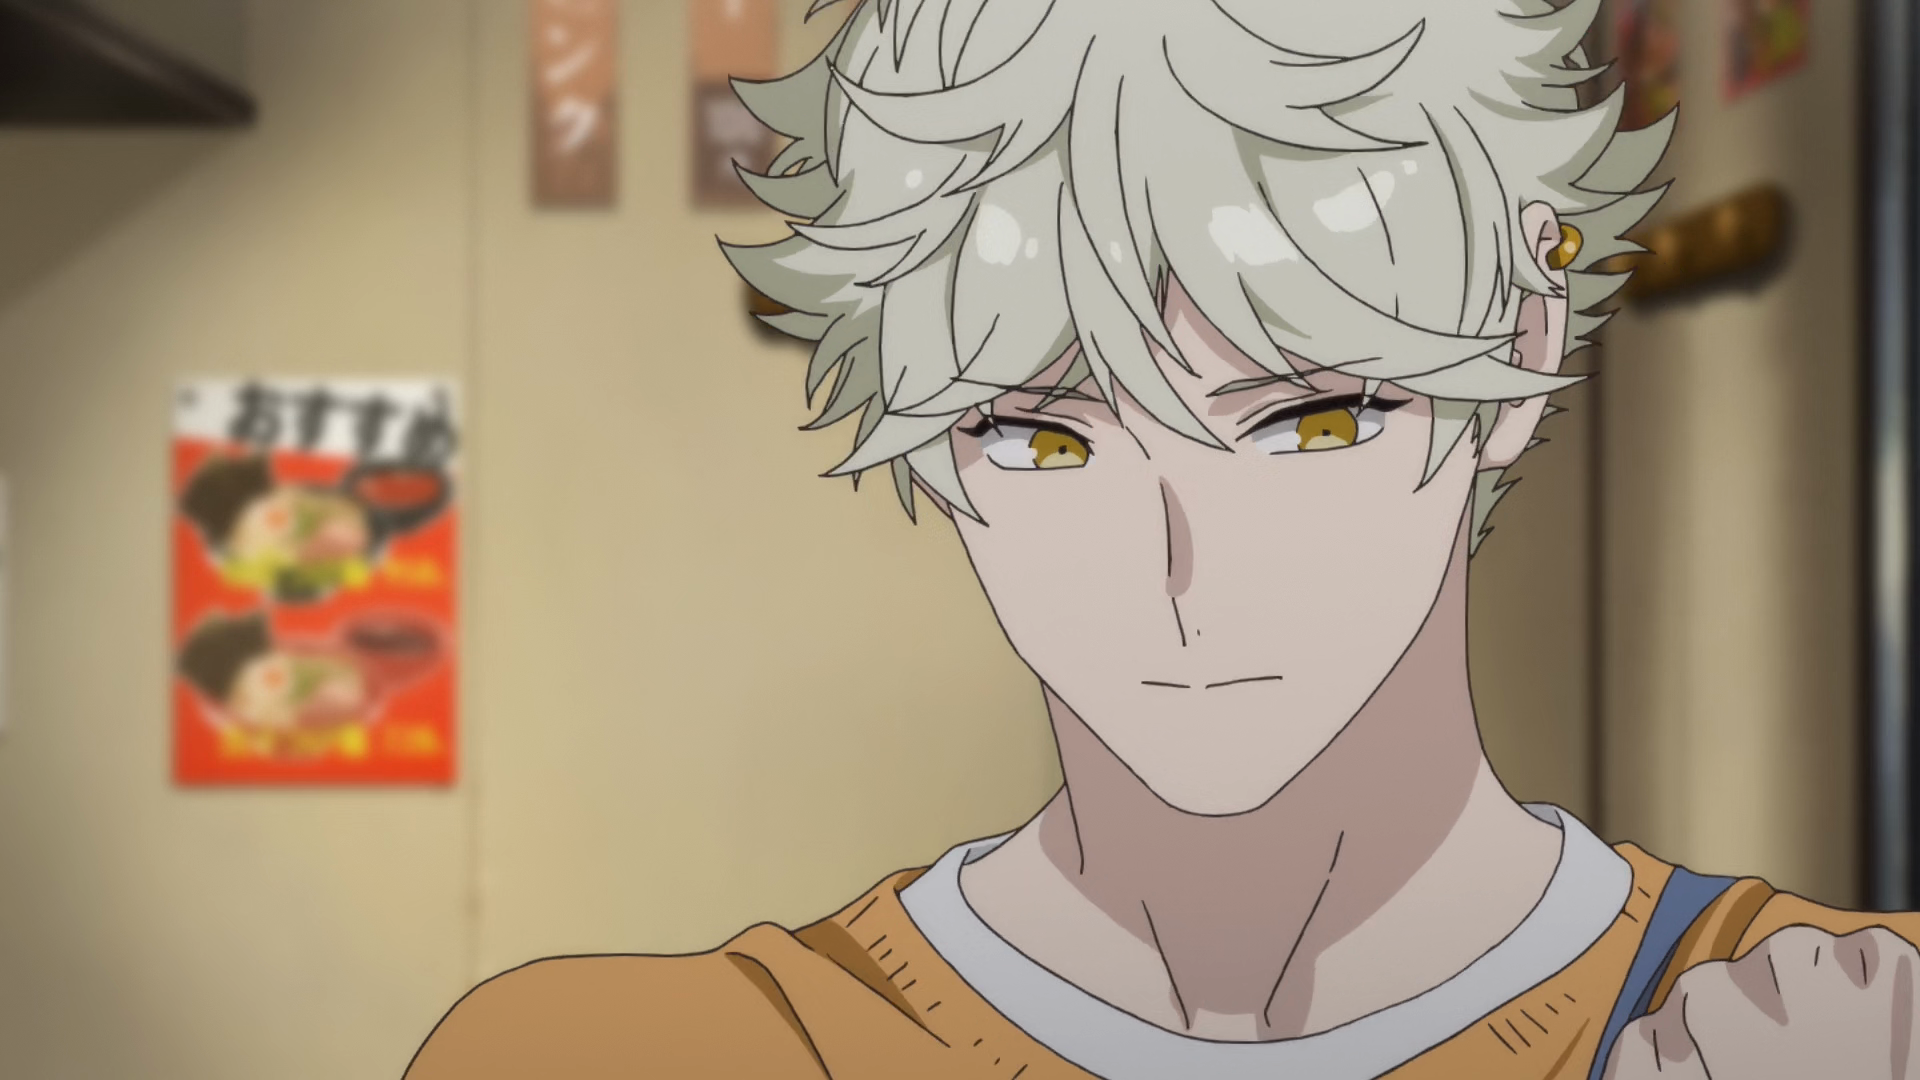

In [21]:
Image.fromarray(frames[0])

In [23]:
import pickle

In [29]:
def save_pk(obj, fname):
    with open("data/"+fname+".pkl", "wb+") as f:
        pickle.dump(obj, f) 

def load_pk(fname):
    with open("data/"+fname+".pkl", "rb+") as f:
        return pickle.load(f) 

In [27]:
from json import load


save_pk(frames, "frames")


In [30]:
frames = load_pk("frames")

# Saving B/W versions of images

In [39]:
from tqdm import tqdm_notebook as tqdm
import os

In [37]:
1080/4, 1920/4

(270.0, 480.0)

In [42]:
resize_to = (480, 270)

In [44]:
for i, frame in tqdm(enumerate(frames), total = len(frames)):
    os.makedirs("data/orig",exist_ok=True)
    os.makedirs("data/bw",exist_ok=True)
    im = Image.fromarray(frame).resize(resize_to)
    im.save(f"data/orig/{i}.png")
    im.convert("L").save(f"data/bw/{i}.png")

/tmp/ipykernel_25126/1807514801.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, frame in tqdm(enumerate(frames), total = len(frames)):


  0%|          | 0/290 [00:00<?, ?it/s]

# Unet

In [21]:
from fastai.vision.all import *

In [22]:
path = Path("data/")

In [23]:
dblock = DataBlock(blocks    = (ImageBlock, ImageBlock),
                   get_items = get_image_files,
                   get_y     = lambda o: path/'orig'/f'{o.stem}{o.suffix}',
                   batch_tfms=[*aug_transforms(size=(256, 384)), Normalize.from_stats(*imagenet_stats)])
dls = dblock.dataloaders(path/"bw", bs=8, path=path)

In [24]:
# dls.show_batch()

In [25]:
def convT_norm_relu(ch_in:int, ch_out:int, norm_layer:nn.Module, ks:int=3, stride:int=2, bias:bool=True):
    return [nn.ConvTranspose2d(ch_in, ch_out, kernel_size=ks, stride=stride, padding=1, output_padding=1, bias=bias),
            norm_layer(ch_out), nn.ReLU(True)]

def pad_conv_norm_relu(ch_in:int, ch_out:int, pad_mode:str, norm_layer:nn.Module, ks:int=3, bias:bool=True, 
                       pad=1, stride:int=1, activ:bool=True, init:Callable=nn.init.kaiming_normal_)->List[nn.Module]:
    layers = []
    if pad_mode == 'reflection': layers.append(nn.ReflectionPad2d(pad))
    elif pad_mode == 'border':   layers.append(nn.ReplicationPad2d(pad))
    p = pad if pad_mode == 'zeros' else 0
    conv = nn.Conv2d(ch_in, ch_out, kernel_size=ks, padding=p, stride=stride, bias=bias)
    if init:
        init(conv.weight)
        if hasattr(conv, 'bias') and hasattr(conv.bias, 'data'): conv.bias.data.fill_(0.)
    layers += [conv, norm_layer(ch_out)]
    if activ: layers.append(nn.ReLU(inplace=True))
    return layers

class ResnetBlock(nn.Module):
    def __init__(self, dim:int, pad_mode:str='reflection', norm_layer:nn.Module=None, dropout:float=0., bias:bool=True):
        super().__init__()
        assert pad_mode in ['zeros', 'reflection', 'border'], f'padding {pad_mode} not implemented.'
        norm_layer = ifnone(norm_layer, nn.InstanceNorm2d)
        layers = pad_conv_norm_relu(dim, dim, pad_mode, norm_layer, bias=bias)
        if dropout != 0: layers.append(nn.Dropout(dropout))
        layers += pad_conv_norm_relu(dim, dim, pad_mode, norm_layer, bias=bias, activ=False)
        self.conv_block = nn.Sequential(*layers)

    def forward(self, x): return x + self.conv_block(x)
def resnet_generator(ch_in:int, ch_out:int, n_ftrs:int=64, norm_layer:nn.Module=None, 
                     dropout:float=0., n_blocks:int=6, pad_mode:str='reflection')->nn.Module:
    norm_layer = ifnone(norm_layer, nn.InstanceNorm2d)
    bias = (norm_layer == nn.InstanceNorm2d)
    layers = pad_conv_norm_relu(ch_in, n_ftrs, 'reflection', norm_layer, pad=3, ks=7, bias=bias)
    for i in range(2):
        layers += pad_conv_norm_relu(n_ftrs, n_ftrs *2, 'zeros', norm_layer, stride=2, bias=bias)
        n_ftrs *= 2
    layers += [ResnetBlock(n_ftrs, pad_mode, norm_layer, dropout, bias) for _ in range(n_blocks)]
    for i in range(2):
        layers += convT_norm_relu(n_ftrs, n_ftrs//2, norm_layer, bias=bias)
        n_ftrs //= 2
    layers += [nn.ReflectionPad2d(3), nn.Conv2d(n_ftrs, ch_out, kernel_size=7, padding=0), nn.Tanh()]
    return nn.Sequential(*layers)

def conv_norm_lr(ch_in:int, ch_out:int, norm_layer:nn.Module=None, ks:int=3, bias:bool=True, pad:int=1, stride:int=1, 
                 activ:bool=True, slope:float=0.2, init:Callable=nn.init.kaiming_normal_)->List[nn.Module]:
    conv = nn.Conv2d(ch_in, ch_out, kernel_size=ks, padding=pad, stride=stride, bias=bias)
    if init:
        init(conv.weight)
        if hasattr(conv, 'bias') and hasattr(conv.bias, 'data'): conv.bias.data.fill_(0.)
    layers = [conv]
    if norm_layer is not None: layers.append(norm_layer(ch_out))
    if activ: layers.append(nn.LeakyReLU(slope, inplace=True))
    return layers
def discriminator(ch_in:int, n_ftrs:int=64, n_layers:int=3, norm_layer:nn.Module=None, sigmoid:bool=False)->nn.Module:
    norm_layer = ifnone(norm_layer, nn.InstanceNorm2d)
    bias = (norm_layer == nn.InstanceNorm2d)
    layers = conv_norm_lr(ch_in, n_ftrs, ks=4, stride=2, pad=1)
    for i in range(n_layers-1):
        new_ftrs = 2*n_ftrs if i <= 3 else n_ftrs
        layers += conv_norm_lr(n_ftrs, new_ftrs, norm_layer, ks=4, stride=2, pad=1, bias=bias)
        n_ftrs = new_ftrs
    new_ftrs = 2*n_ftrs if n_layers <=3 else n_ftrs
    layers += conv_norm_lr(n_ftrs, new_ftrs, norm_layer, ks=4, stride=1, pad=1, bias=bias)
    layers.append(nn.Conv2d(new_ftrs, 1, kernel_size=4, stride=1, padding=1))
    if sigmoid: layers.append(nn.Sigmoid())
    return nn.Sequential(*layers)

class CycleGAN(nn.Module):
    
    def __init__(self, ch_in:int, ch_out:int, n_features:int=64, disc_layers:int=3, gen_blocks:int=6, lsgan:bool=True, 
                 drop:float=0., norm_layer:nn.Module=None):
        super().__init__()
        self.D_A = discriminator(ch_in, n_features, disc_layers, norm_layer, sigmoid=not lsgan)
        self.D_B = discriminator(ch_in, n_features, disc_layers, norm_layer, sigmoid=not lsgan)
        self.G_A = resnet_generator(ch_in, ch_out, n_features, norm_layer, drop, gen_blocks)
        self.G_B = resnet_generator(ch_in, ch_out, n_features, norm_layer, drop, gen_blocks)
        #G_A: takes real input B and generates fake input A
        #G_B: takes real input A and generates fake input B
        #D_A: trained to make the difference between real input A and fake input A
        #D_B: trained to make the difference between real input B and fake input B
    
    def forward(self, real_A, real_B):
        fake_A, fake_B = self.G_A(real_B), self.G_B(real_A)
        if not self.training: return torch.cat([fake_A[:,None],fake_B[:,None]], 1)
        idt_A, idt_B = self.G_A(real_A), self.G_B(real_B) #Needed for the identity loss during training.
        return [fake_A, fake_B, idt_A, idt_B]

In [26]:
class AdaptiveLoss(nn.Module):
    def __init__(self, crit):
        super().__init__()
        self.crit = crit
    
    def forward(self, output, target:bool, **kwargs):
        targ = output.new_ones(*output.size()) if target else output.new_zeros(*output.size())
        return self.crit(output, targ, **kwargs)

class CycleGanLoss(nn.Module):
    
    def __init__(self, cgan:nn.Module, lambda_A:float=10., lambda_B:float=10, lambda_idt:float=0.5, lsgan:bool=True):
        super().__init__()
        self.cgan,self.l_A,self.l_B,self.l_idt = cgan,lambda_A,lambda_B,lambda_idt
        self.crit = AdaptiveLoss(F.mse_loss if lsgan else F.binary_cross_entropy)
    
    def set_input(self, input):
        self.real_A,self.real_B = input
    
    def forward(self, output, target):
        fake_A, fake_B, idt_A, idt_B = output
        #Generators should return identity on the datasets they try to convert to
        self.id_loss = self.l_idt * (self.l_A * F.l1_loss(idt_A, self.real_A) + self.l_B * F.l1_loss(idt_B, self.real_B))
        #Generators are trained to trick the discriminators so the following should be ones
        self.gen_loss = self.crit(self.cgan.D_A(fake_A), True) + self.crit(self.cgan.D_B(fake_B), True)
        #Cycle loss
        self.cyc_loss  = self.l_A * F.l1_loss(self.cgan.G_A(fake_B), self.real_A)
        self.cyc_loss += self.l_B * F.l1_loss(self.cgan.G_B(fake_A), self.real_B)
        return self.id_loss+self.gen_loss+self.cyc_loss

In [27]:
model = CycleGAN(3,3, gen_blocks=9)

In [28]:
learn = Learner(dls, model, loss_func=MSELossFlat)

In [29]:
learn.fit(1)

epoch,train_loss,valid_loss,time


TypeError: CycleGAN.forward() missing 1 required positional argument: 'real_B'